In [3]:
import os
import pandas as pd 
import numpy as np

import statsmodels.api as sm
from itertools import cycle
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.metrics import r2_score, make_scorer
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

/Users/pasquierjb/anaconda3/envs/hrm/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load configurations

In [4]:
import yaml

with open('../public_config.yml', 'r') as cfgfile:
    public_config = yaml.load(cfgfile)

public_config

{'dataset': {'country': 'Uganda',
  'filename': 'WB_Uganda_2011_cluster.csv',
  'level': 'cluster',
  'month': 1,
  'source': 'WB',
  'year': 2011},
 'network': {'layer': 'AvgPool', 'model': 'ResNet50'},
 'satellite': {'grid': 'F182013.v4c_web.stable_lights.avg_vis.tif',
  'source': 'Google',
  'step': 0}}

# 1. Preparing Data

### Loading HH Data

In [5]:
#hh_data = pd.read_csv("../Data/Datasets/{}".format(public_config["dataset"]["filename"]))

In [6]:
hh_data = pd.read_csv("../Data/Satellite/Sentinel/vam_uganda_karamoja_2016_maxNDVI_1km.csv")

In [7]:
hh_data.head()

,index,village,Latitude,Longitude,asset_score,FCS,n,i,j,mean_maxNDVI_2016_1km
0,0,Abim East,2.708589,33.665483,3.100000,44.050000,10,25640,8675,0.656347
1,1,Acan Penino,2.848594,33.694574,2.111111,35.750000,18,25643,8658,0.689287
2,2,Acek Abuk,2.746334,33.673905,2.000000,41.111111,9,25641,8670,0.670488
3,4,Adipala,2.450002,34.322738,0.300000,26.525000,20,25719,8706,0.418286
4,5,Agule,2.493331,33.897964,1.947368,22.842105,19,25668,8701,0.567810


In [8]:
hh_data["mean_maxNDVI_2016_1km"].corr(hh_data["FCS"])

0.03051340407722063

### Loading CNN features

In [9]:
CNN_features = pd.read_csv("../Data/Features/{}_{}_{}_{}.csv".format(public_config["dataset"]["source"], \
                                                       public_config["dataset"]["country"], \
                                                       public_config["network"]["model"], \
                                                       public_config["network"]["layer"]))

In [10]:
file="/Users/pasquierjb/Google Drive/WFP_Shared/Projects/Back_ups /HRM_backup/Data/Intermediate_files/bing_sat_CNN_features_vam_ResNet_tf_last.csv"
CNN_features = pd.read_csv(file)

### Loading Additional Features

In [11]:
#NDVI = pd.read_csv("

### Merging

In [12]:
data=hh_data.merge(CNN_features,on=["i","j"])

In [13]:
data = data.sample(frac=1, random_state=1783).reset_index(drop=True) #Shuffling the data

In [14]:
start_features=len(hh_data.columns)+2

In [15]:
data_features=data.iloc[:,start_features:]

In [16]:
data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.851058,0.534559,0.168120,0.011578,0.046766,0.081729,0.149118,0.001147,0.005397,0.002196,...,0.000000,0.000000,0.108957,0.002891,0.064581,1.130369,0.036919,0.477293,0.254624,0.035668
1,0.273183,0.377056,0.032655,0.953597,0.006501,0.000000,0.000000,0.083926,0.000000,0.002928,...,0.000000,0.000000,0.000000,0.048215,0.006943,0.050562,0.011586,2.898155,0.025612,0.115990
2,0.773727,0.499619,0.482391,0.224194,0.166067,0.000000,0.021172,0.010604,0.000000,0.024432,...,0.000725,0.000000,0.000599,0.000000,0.000000,0.356096,0.003666,0.523456,0.066297,0.165208
3,0.258952,1.006318,0.348424,0.067091,0.014995,0.036087,0.003191,0.032351,0.000000,0.000000,...,0.035567,0.003120,0.024583,0.071973,0.082299,0.820550,0.022809,0.810718,0.054079,0.287897
4,0.834517,0.532984,0.098913,0.043069,0.082437,0.000629,0.134732,0.024592,0.000000,0.000000,...,0.000000,0.009285,0.018177,0.000000,0.160182,0.683553,0.001051,0.340110,0.153021,0.045013


### Defining predictors and predicting variables

In [17]:
y = data["FCS"].values #Average normalized consumption per cluster
#y = y[y > 0]
#y = np.log(y) #Log-normal distribution

In [18]:
#y2 = data["poor_majority"] #Dummy variable for majority of poor in the cluster

In [19]:
X=data_features.values

In [291]:
NDVI=data["mean_maxNDVI_2016_1km"].values
#NDVI=data["mean_meanNDVI_2016_1km"].values

In [292]:
X_NDVI=pd.concat([pd.DataFrame(X),pd.DataFrame(NDVI)],axis=1).values

In [293]:
X_NDVI.shape

(224, 2049)

In [294]:
X.shape

(224, 2048)

In [295]:
y.shape

(224,)

(array([ 10.,  33.,  55.,  49.,  32.,  27.,   7.,   5.,   4.,   2.]),
 array([ 16.88888889,  22.91666667,  28.94444445,  34.97222222,
         41.        ,  47.02777778,  53.05555556,  59.08333334,
         65.11111111,  71.13888889,  77.16666667]),
 <a list of 10 Patch objects>)

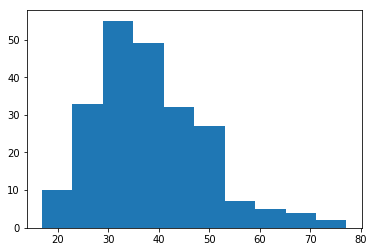

In [296]:
plt.hist(y)

In [297]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.851058,0.534559,0.168120,0.011578,0.046766,0.081729,0.149118,0.001147,0.005397,0.002196,...,0.000000,0.000000,0.108957,0.002891,0.064581,1.130369,0.036919,0.477293,0.254624,0.035668
1,0.273183,0.377056,0.032655,0.953597,0.006501,0.000000,0.000000,0.083926,0.000000,0.002928,...,0.000000,0.000000,0.000000,0.048215,0.006943,0.050562,0.011586,2.898155,0.025612,0.115990
2,0.773727,0.499619,0.482391,0.224194,0.166067,0.000000,0.021172,0.010604,0.000000,0.024432,...,0.000725,0.000000,0.000599,0.000000,0.000000,0.356096,0.003666,0.523456,0.066297,0.165208
3,0.258952,1.006318,0.348424,0.067091,0.014995,0.036087,0.003191,0.032351,0.000000,0.000000,...,0.035567,0.003120,0.024583,0.071973,0.082299,0.820550,0.022809,0.810718,0.054079,0.287897
4,0.834517,0.532984,0.098913,0.043069,0.082437,0.000629,0.134732,0.024592,0.000000,0.000000,...,0.000000,0.009285,0.018177,0.000000,0.160182,0.683553,0.001051,0.340110,0.153021,0.045013


# 2. Predicting Continuous Indicator

In [20]:
alphas = np.array([0.01,0.1,1,5,10,20,30,40,50])

In [21]:
model=Ridge()

In [22]:
inner_cv = KFold(n_splits=5, shuffle=True, random_state=1673)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=75788)

In [23]:
def r2_pearson(ground_truth, predictions):
    r2_pearson=stats.pearsonr(ground_truth, predictions)[0] ** 2
    return r2_pearson
r2_pearson = make_scorer(r2_pearson, greater_is_better=True)

In [24]:
#Inner cross-validation loop
clf = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=inner_cv, scoring=r2_pearson)

## From PCA Components

In [25]:
pca = PCA(n_components=10)

In [26]:
pca.fit(data_features.transpose())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
eigenvectors=pca.components_

In [28]:
X2 = pd.DataFrame(np.transpose(eigenvectors))
X2.shape

(224, 10)

In [29]:
NDVI=data["mean_maxNDVI_2016_1km"].values

In [30]:
X2_NDVI=pd.concat([pd.DataFrame(X2),pd.DataFrame(NDVI)],axis=1).values

In [33]:
X2_NDVI.shape

(224, 11)

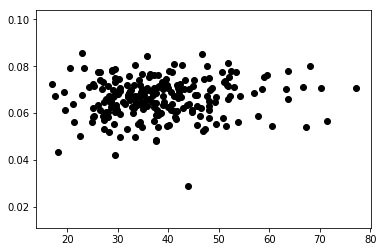

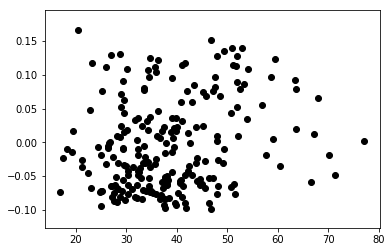

In [34]:
for i in range(2):
    plt.figure()
    plt.scatter(y, eigenvectors[i],  color='black')

In [42]:
X2.describe()

,0,1,2,3,4,5,6,7,8,9
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,0.066293,-0.004668,-0.000994,0.000357,-0.000346,0.002046,-0.002404,-0.000623,-0.000046,0.001309
std,0.008359,0.066801,0.066958,0.066964,0.066964,0.066934,0.066922,0.066962,0.066965,0.066952
min,0.029085,-0.098001,-0.190030,-0.147892,-0.134802,-0.137233,-0.236780,-0.173093,-0.210492,-0.193510
25%,0.061149,-0.062262,-0.044806,-0.048292,-0.049881,-0.045753,-0.045916,-0.045282,-0.045370,-0.042407
50%,0.067171,-0.020503,0.003092,-0.012852,-0.007670,0.003255,0.004311,-0.002620,0.003075,0.003256
75%,0.071675,0.036830,0.050572,0.052741,0.033324,0.045238,0.049226,0.040800,0.051299,0.043285
max,0.085792,0.166882,0.139552,0.171576,0.189515,0.168968,0.153747,0.249994,0.183146,0.219572


In [44]:
pd.DataFrame(X2_NDVI).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,0.066293,-0.004668,-0.000994,0.000357,-0.000346,0.002046,-0.002404,-0.000623,-0.000046,0.001309,0.533218
std,0.008359,0.066801,0.066958,0.066964,0.066964,0.066934,0.066922,0.066962,0.066965,0.066952,0.086130
min,0.029085,-0.098001,-0.190030,-0.147892,-0.134802,-0.137233,-0.236780,-0.173093,-0.210492,-0.193510,0.293702
25%,0.061149,-0.062262,-0.044806,-0.048292,-0.049881,-0.045753,-0.045916,-0.045282,-0.045370,-0.042407,0.466799
50%,0.067171,-0.020503,0.003092,-0.012852,-0.007670,0.003255,0.004311,-0.002620,0.003075,0.003256,0.532042
75%,0.071675,0.036830,0.050572,0.052741,0.033324,0.045238,0.049226,0.040800,0.051299,0.043285,0.592117
max,0.085792,0.166882,0.139552,0.171576,0.189515,0.168968,0.153747,0.249994,0.183146,0.219572,0.753296


In [48]:
from sklearn.preprocessing import normalize
X2_NDVI = normalize(X2_NDVI)

In [49]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X2, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

r2 (pearson): 0.18 (+/- 0.16)


In [50]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X2_NDVI, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2)) 

r2 (pearson): 0.17 (+/- 0.14)


In [51]:
# Outer Loop with R2
r2 = cross_val_score(clf, X2, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

R2: 0.09 (+/- 0.26)


In [52]:
# Outer Loop with R2
r2 = cross_val_score(clf, X2_NDVI, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

R2: 0.08 (+/- 0.25)


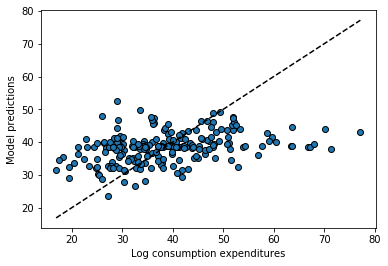

In [310]:
y_hat = cross_val_predict(clf, X2, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

## From all (4096) features

In [311]:
alphas = np.array([1,5,10,20,30,40,50])

In [312]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

r2 (pearson): 0.26 (+/- 0.15)


In [313]:
# Outer Loop with r2 (Pearson)
r2 = cross_val_score(clf, X_NDVI, y, cv=outer_cv ,scoring=r2_pearson)
print("r2 (pearson): %0.2f (+/- %0.2f)" % (r2.mean(), r2.std() * 2))

r2 (pearson): 0.26 (+/- 0.15)


In [314]:
r2

array([ 0.31800184,  0.1705986 ,  0.34122141,  0.16119973,  0.29420097])

In [315]:
# Outer Loop with R2
R2 = cross_val_score(clf, X, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.19 (+/- 0.14)


In [316]:
# Outer Loop with R2
R2 = cross_val_score(clf, X_NDVI, y, cv=outer_cv ,scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (R2.mean(), R2.std() * 2))

R2: 0.19 (+/- 0.14)


In [317]:
R2

array([ 0.25822371,  0.12174636,  0.20193324,  0.10557578,  0.28646075])

In [318]:
neg_mean_squared_error = cross_val_score(clf, X, y, cv=outer_cv,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (-neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: 93.96 (+/- 47.78)


In [319]:
neg_mean_squared_error = cross_val_score(clf, X_NDVI, y, cv=outer_cv,scoring='neg_mean_squared_error')
print("neg_mean_squared_error: %0.2f (+/- %0.2f)" % (-neg_mean_squared_error.mean(), neg_mean_squared_error.std() * 2)) 

neg_mean_squared_error: 93.97 (+/- 47.79)


In [320]:
-neg_mean_squared_error

array([  90.98483623,  130.73597761,   55.6074132 ,   93.81179865,
         98.69556776])

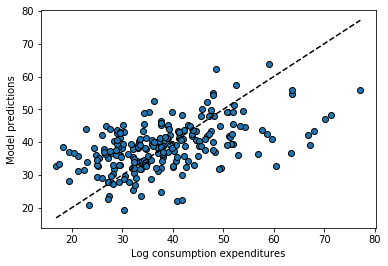

In [272]:
y_hat = cross_val_predict(clf, X, y, cv=outer_cv)
fig, ax = plt.subplots()
ax.scatter(y, y_hat, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
ax.set_xlabel('Log consumption expenditures')
ax.set_ylabel('Model predictions')
plt.show()

In [273]:
r2_score(y,y_hat)

0.23375146955068393

In [274]:
stats.pearsonr(y,y_hat)[0] ** 2

0.2597462669470485

# 3. Predicting Dummy Indicator from all features

In [40]:
model = linear_model.LogisticRegression(penalty="l2")
model.fit(X, y2) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
cv = KFold(n_splits=10, shuffle=True, random_state=167)

In [42]:
accuracy = cross_val_score(model, X, y2, cv=cv)
f1 = cross_val_score(model, X, y2, cv=cv,scoring='f1')
precision = cross_val_score(model, X, y2, cv=cv,scoring='precision')
recall= cross_val_score(model, X, y2, cv=cv,scoring='recall')
auc= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')
confusion= cross_val_score(model, X, y2, cv=cv,scoring='roc_auc')

In [43]:
scores = cross_val_score(model, X, y2, cv=10,scoring='precision')
accuracy_print=("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
f1_print=("F1: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))
precision_print=("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
recall_print=("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
auc_print=("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))
print(os.linesep.join([accuracy_print,f1_print,precision_print,recall_print,auc_print]))

Accuracy: 0.79 (+/- 0.09)
F1: 0.53 (+/- 0.26)
Precision: 0.62 (+/- 0.37)
Recall: 0.49 (+/- 0.30)
AUC: 0.82 (+/- 0.14)


In [44]:
y2.describe()

count    309.000000
mean       0.258900
std        0.438741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: poor_majority, dtype: float64

# 4. Predicting Dummy Indicator from all features

In [86]:
clf.fit(X,y)
y_hat = clf.predict(X)
y_hat=pd.Series(y_hat,name='y_hat')

In [90]:
predictions=pd.concat([hh_data,y_hat],axis=1)

In [91]:
hh_data = predictions.to_csv("../Data/Results/pred_{}".format(public_config["dataset"]["filename"]))